# Problema de llenado de tanques. Bertsekas Vol1 - pag 143
---
## Descripcion

Se plantea el problema de controlar el flujo de entrada al tanque 1 de manera de lograr que arrancando en $t=0$ con ambos tanques vacios, alcancemos el tiempo $t=1$ con el tanque 1 en cota $x_1=0.5$ y el tanque 2 en una cota lo  maxima posible.
<img src="Reservoirs_Original.png">

El sistema dinamico es:

$$\left\{
\begin{eqnarray} 
    \dot{x}_1 &=& u - x_1 \\
    \dot{x}_2 &=& x_1
\end{eqnarray}
\right.$$

Con condiciones inciales $x_1(0)=0$ y $x_2(0)=0$.

Se busca controlar el caudal de entrada ($u$) sujeto a que $|u|\leq 1$, de tal forma que $x_1(1)=0.5$ y se maximice $x_2(1)$.

## Solucion Mediante Principio del Minimo de Pontryagin

Buscamos maximizar el nivel o cota del tanque 2 en el tiempo $t=1$. Esto se traduce en un costo terminal $h(x(T))=-x_2(T)$, con $T=1$. El signo de menos corresponde a querer maximizar. Notamos que no hay costo corriente ($g(x,u)=0$).

Dado que tenemos dos variables de estado ($x_1$ y $x_2$) en la dinamica, formamos el siguiente Hamiltoniano:

$$\begin{eqnarray}
H(x,u,p) &=& g(x,u) + p^T f(x,u) \\
&=& p_1(u-x_1) + p_2 x_1
\end{eqnarray}$$

Las ecuaciones adjuntas estan dadas por: $\dot{p}=-\nabla_x H(x,u,p)$:

$$\left\{
\begin{eqnarray} 
    \dot{p}_1 &=& p_1 - p_2 \\
    \dot{p}_2 &=& 0
\end{eqnarray}
\right.$$

Con condicion de borde $p_2(T)=\frac{\partial}{\partial x^*_2} h(x^*(T)) = -1$. Entonces, podemos afirmar que $p_2=-1$ para todo $t\in [0,1]$.

Eso implica que se cumple la ecuacion: $\dot{p}_1 = p_1 +1$. Cuya solucion es

$$p_1(t) = a e^t -1$$

Adicionalmente a lo anterior, el principio del minimo requiere que el control optimo $u^*$ cumpla $\forall t$:

$$u^* = \arg\min_{u \in U} H(x^*(t),u,p(t))$$

Si minimizamos el Hamiltoniano respecto de $u$, al ser lineal en $u$, concluimos que:

$$u^* = 1 \text{   si   }p_1<0$$

$$u^* = 0 \text{   si   }p_1>0$$

De la solucion hallada para $p_1(t)$, concluimos que:

1. Si $a>1$ no obtenemos una solucion factible ($u^*=0\forall t$).

2. Si $a<1$ podemos tener una solucion factible:
  * Si $a>1/e$ entonces hay un switch ($u^*=1 \rightarrow u^*=0$)
  * Si $a<1/e$ entonces no hay switch ($u^*=1$)

La solucion de interes con un switch es control de tipo Bang-Bang. 

Resolviendo la dinamica entre $[0,t_o]$ con {$u=1$,$x_1(0)=0$} y entre $[t_o,1]$ con {$u=0$,$x_1(1)=0.5$}, obtenemos el siguiente valor para $t_o$.

$$t_o = \ln\left(1+ \frac{e}{2} \right)\simeq 0.85830$$

## Solucion Numerica con JuMP

In [ ]:
import Pkg

In [ ]:
#Pkg.add("Clp")
Pkg.add("GLPK") # solo una vez

In [1]:
#using JuMP, GLPK
using JuMP, GLPK

In [2]:
# Codigo basado en ejemplo "Rocket Control" (https://www.juliaopt.org/notebooks/JuMP-Rocket.html)

# Creo el modelo usando JuMP, uso GLPK como solver, el problema es LP
mod = Model(with_optimizer(GLPK.Optimizer))

# Ejemplo de llenado de un tanque a traves de vaciado de otro
# de manera de llegar a t=1 con el primer tanque 50% lleno y el segundo con cota maxima.

x1_0 = 0    # Cota Tanque 1 Inicial
x2_0 = 0    # Cota Tanque 2 Inicial

n = 100                                   # Numero de Pasos Temporales
t_f = 1                                    # Tiempo Final
Δt = 1/n                                   # Intervalo de Tiempo

# Variables Dinamicas
@variable(mod, x1[0:n] )          # Cota Tanque 1
@variable(mod, x2[0:n] )          # Cota Tanque 2

# Control: Caudal de llenado en Tanque 1
@variable(mod, 0 ≤ u[0:n] ≤ 1)

# Objetivo: Maximizar cota tanque 2 en t=1
@objective(mod, Max, x2[n])

# Condiciones Iniciales
@constraint(mod, x1[0] == x1_0)
@constraint(mod, x2[0] == x2_0)

# Condiciones Finales
@constraint(mod, x1[n] == 0.5)

# Dinamica
for j in 1:n
    # x1' = -x1+u
    # Regla del Trapecio
    @constraint(mod,
    x1[j] == x1[j-1] + 0.5*Δt*(-x1[j]+u[j]-x1[j-1]+u[j-1]))

    # x2' = x1
    # Regla del Trapecio
    @constraint(mod,
    x2[j] == x2[j-1] + 0.5*Δt*(x1[j]+x1[j-1]))
end

# Imprimo Proble de Optimizacion (mod)
#print(mod)
println("")

# Resolvemos variables de estado y de control
println("Solving...")
optimize!(mod)

# Mostramos resultados
println("Estado del Solver: ", termination_status(mod))
println("Cota Maxima En Tanque 2 @(t=1): ", objective_value(mod))


Solving...
Estado del Solver: OPTIMAL
Cota Maxima En Tanque 2 @(t=1): 0.35827166263815496


## Representacion Grafica de Solucion Numerica

In [ ]:
#Pkg.add("Gadfly") # solo una vez

In [3]:
using Gadfly

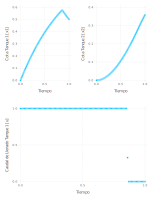

In [4]:
x1_plot = plot(x=(0:n)*Δt,y=[value(x1[i]) for i in eachindex(x1)], Geom.point,
Guide.xlabel("Tiempo"), Guide.ylabel("Cota Tanque 1 [x1]"))

x2_plot = plot(x=(0:n)*Δt,y=[value(x2[i]) for i in eachindex(x2)], Geom.point,
Guide.xlabel("Tiempo"), Guide.ylabel("Cota Tanque 2 [x2]"))

u_plot = plot(x=(0:n)*Δt,y=[value(u[i]) for i in eachindex(u)], Geom.point,
Guide.xlabel("Tiempo"), Guide.ylabel("Caudal de Llenado Tanque 1 [u]"))

draw(SVG(6inch, 8inch), vstack(hstack(x1_plot,x2_plot), u_plot))

In [5]:
t_o = sum(map(value, u))/n

0.8632716626381503